In [2]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [3]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings 
using Optim
using KernelFunctions, MAT, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 

import RxInfer: PointMassFormConstraint,call_boundaries, call_starting_point

In [4]:
include("UniSGPnode.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

In [5]:
Random.seed!(3)
xmin, xmax = -4, 4  # Bounds of the data
N = 50# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=600));
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

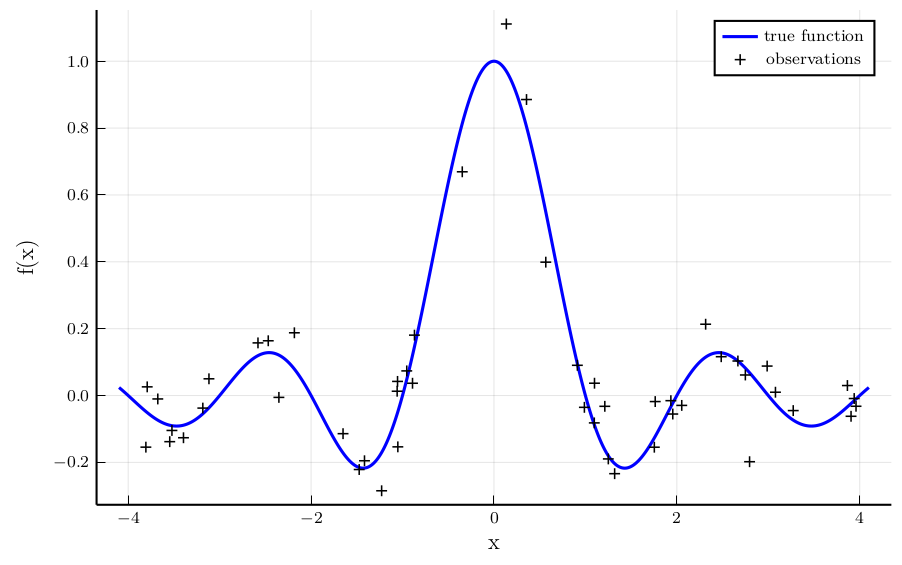

In [6]:
#Data visualization
plot(xtest,f_true,linewidth=1.5,label="true function", color =:blue)
scatter!(xtrain,ytrain, alpha=1, label="observations", ms=3.5, marker=:cross, legend=:topright)
xlabel!("x")
ylabel!("f(x)")

## Regression model

In [7]:
@model function gp_regression(y,x,Xu,θ)

    v ~ MvNormalMeanCovariance(zeros(length(Xu)), 50diageye(length(Xu)))
    w ~ GammaShapeRate(1e-2,1e-2)
    for i in eachindex(y)
        y[i] ~ UniSGP(x[i],v,w,θ) 
    end
end

gp_constraints = @constraints begin
    q(v,w) = q(v)q(w)
end

@meta function meta_gp_regression(Xu,kernel)
    UniSGP() -> UniSGPMeta(nothing,Xu,kernel)
end

gp_initialization = @initialization begin
    q(w) = GammaShapeRate(1e-2,1e-2)
end

Initial state: 
  q(w) = GammaShapeRate{Float64}(a=0.01, b=0.01)


In [8]:
Nu = 20; #number of inducing points 

Xu = range(-4,4;length=Nu);
mean_gp = (x) -> 0
kernel_gp(θ) = θ[1] * with_lengthscale(SEKernel(),θ[2])

kernel_gp (generic function with 1 method)

In [10]:
function my_free_energy(θ)
    
    infer_result = infer(
        model = gp_regression(Xu = Xu, θ = θ),
        iterations = 10,
        data = (y = ytrain, x = xtrain,),
        initialization = gp_initialization,
        constraints = gp_constraints,
        meta = meta_gp_regression(Xu,kernel_gp),
        free_energy = true,
    )
    
    return infer_result.free_energy[end]
end

function learn_params(θ,iteration)
    lower = [0.1,0.1]
    upper = [10,10]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iteration))
    return res.minimizer
end

learn_params (generic function with 1 method)

In [15]:
θ_init = [1.,1.]
θ_optimal = learn_params(θ_init,50)

2-element Vector{Float64}:
 0.1000001245147034
 0.7214671054844451

In [11]:
niter = 10

infer_result = infer(
    model = gp_regression(Xu = Xu, θ = θ_optimal,),
    iterations = niter,
    data = (y = ytrain, x = xtrain,),
    initialization = gp_initialization,
    constraints = gp_constraints,
    meta = meta_gp_regression(Xu,kernel_gp),
    returnvars = (v = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = false
)

Inference results:
  Posteriors       | available for (w, v)
  Free Energy:     | Real[33.1264, 2.88092, -13.4304, -17.6085, -18.043, -18.0674, -18.0684, -18.0684, -18.0684, -18.0684]


In [12]:
qv = infer_result.posteriors[:v]
qw = infer_result.posteriors[:w];

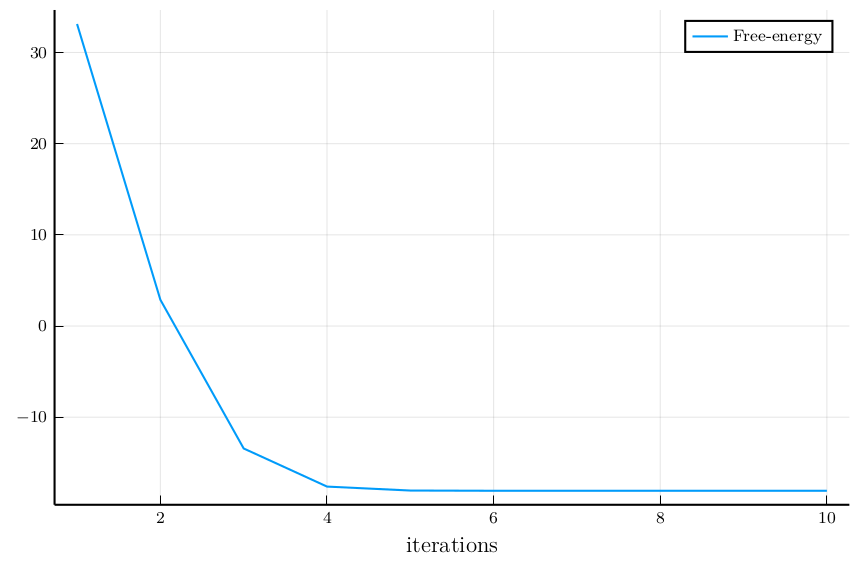

In [13]:
plot(infer_result.free_energy,label="Free-energy", legend=:topright)
xlabel!("iterations")

In [14]:
##prediction
function predict_new(x_test,qv,qw,qθ, meta)
    prediction = @call_rule UniSGP(:out, Marginalisation) (q_in=PointMass(x_test),q_v = qv, q_w = qw,q_θ=qθ, meta=meta)
    return prediction
end

predict_new (generic function with 1 method)

In [15]:
predict_mean =[]
predict_var =[]
for i=1:length(xtest)
    prediction = predict_new(xtest[i],qv,qw,PointMass(θ_optimal),UniSGPMeta(nothing,Xu,kernel_gp))
    append!(predict_mean,mean(prediction))
    append!(predict_var,var(prediction)) 
end

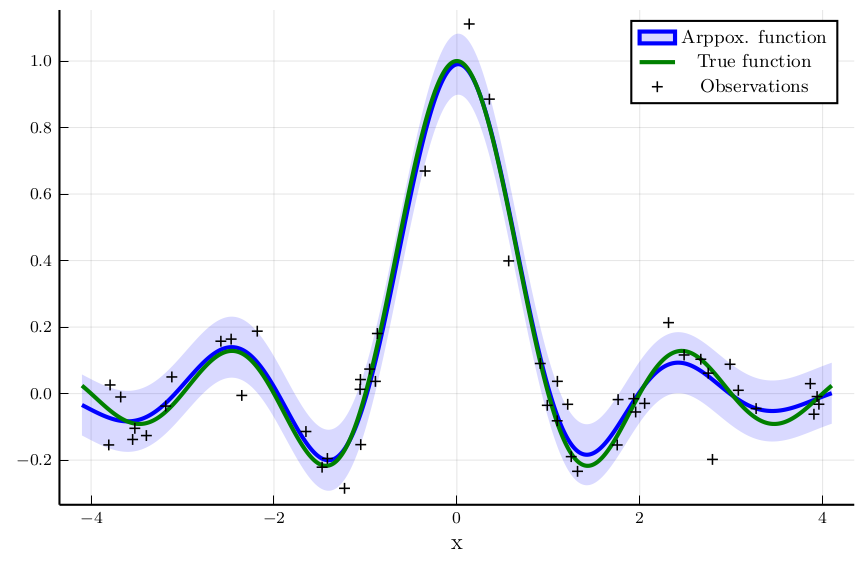

In [52]:
plot(xtest,predict_mean,ribbon = sqrt.(predict_var),
    label="Arppox. function", lw=2,legend=:topright, color=:blue, fillalpha=0.15, fontfamily="monospace",legendfontsize=9)
plot!(xtest,f_true,label="True function",lw=2, color=:green)
scatter!(xtrain,ytrain, label="Observations",  alpha=1, ms=3.5, marker=:cross)
xlabel!("x")

In [53]:
savefig("texfiles/regression_result.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/regression_result.svg"

In [35]:
using GaussianProcesses

In [36]:
Random.seed!(20140430)
mZero = MeanZero()                   #Zero mean function
kern = SE(log(0.1),log(0.8))                   #Sqaured exponential kernel (note that hyperparameters are on the log scale)

logObsNoise = log(1/sqrt(precision))                      # log standard deviation of observation noise (this is optional)
gp = GP(xtrain,ytrain,mZero,kern,logObsNoise) 
optimize!(gp; method=ConjugateGradient())
μ, σ² = predict_y(gp,xtest);

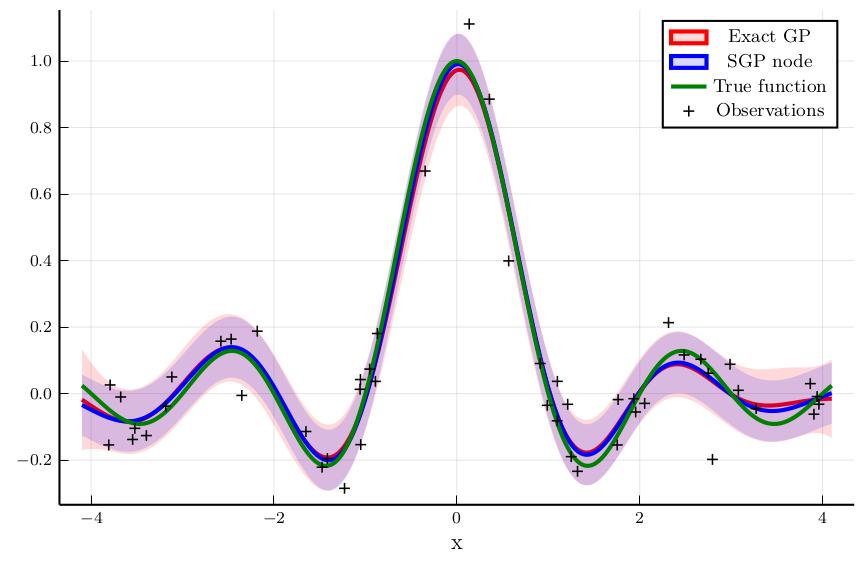

In [54]:
plot(xtest, μ, lw=2,ribbon = sqrt.(σ²), label="Exact GP", legend=:topright,color=:red,fillalpha=0.15, fontfamily="monospace",legendfontsize=9) 
plot!(xtest,predict_mean,lw=2, ribbon = sqrt.(predict_var),label="SGP node",color=:blue,fillalpha=0.15)
plot!(xtest,f_true,lw=2, label="True function",color=:green)
scatter!(xtrain,ytrain, label="Observations",  alpha=1, ms=3.5, marker=:cross)
xlabel!("x")

In [55]:
savefig("texfiles/regression_compare.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/regression_compare.svg"

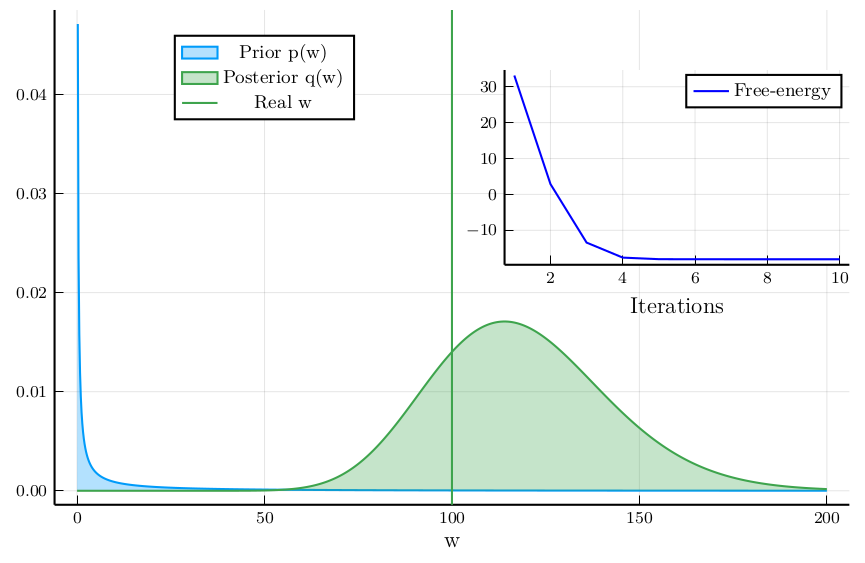

In [58]:
rw = range(0,200,length = 1000)


plot(rw, (x) -> pdf(GammaShapeRate(1e-2, 1e-2), x), fillalpha=0.3, fillrange = 0, label="Prior p(w)", c=1, fontfamily="monospace",legendfontsize=9)
plot!(rw, (x) -> pdf(qw, x), fillalpha=0.3, fillrange = 0, label="Posterior q(w)", c=3, legend_position=(0.15,0.95))
vline!([precision], label="Real w")
xlabel!("w")

plot!(infer_result.free_energy,label="Free-energy", legend=:topright, xlabel="Iterations",
        fontfamily="monospace",legendfontsize=9,
        color=:blue,
        inset = (1, bbox(0.0, 0.1, 0.5, 0.5, :top, :right)),
        subplot = 2)

In [59]:
savefig("texfiles/regression_result_W.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/regression_result_W.svg"

In [32]:
function rmse_score(y_predict, y_true)
    return sqrt(mean((y_predict - y_true).^2))
end
mse_GP_package = rmse_score(f_true, μ)
mse_node = rmse_score(f_true, predict_mean)
println("The mse of SGP node: $mse_node")
println("The mse of the GP package: $mse_GP_package")

The mse of SGP node: 0.023135605944731324
The mse of the GP package: 0.029158991431552955
